In [1]:
# pip install yellowbrick
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.width', 500)
#adjusting the display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_ = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")
df = df_.copy()

# Customer Segmentation with K-Means

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.select_dtypes(include=[np.number]).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

In [4]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [5]:
df["frequency"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["monetary"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [6]:
analysis_date = df['last_order_date'].max() + dt.timedelta(days=2)
df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (analysis_date - df["first_order_date"]).dt.days

In [7]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,frequency,monetary,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370,95,214
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550,105,1574
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320,186,552
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970,135,146
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980,86,668


In [8]:
# copying the recently derived  "frequency","monetary","recency","tenure" columns and re-creating the df dataframe
df = df[["frequency","monetary","recency","tenure"]].copy()
df.head()

,frequency,monetary,recency,tenure
0,5.000,939.370,95,214
1,21.000,2013.550,105,1574
2,5.000,585.320,186,552
3,2.000,121.970,135,146
4,2.000,209.980,86,668


In [9]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #date cols
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'datetime64[ns]']


    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat and col not in date_cols]


    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'date_cols: {len(date_cols)}')

    return cat_cols, num_cols, cat_but_car, date_cols

cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)

Observations: 19945
Variables: 4
cat_cols: 0
num_cols: 4
cat_but_car: 0
num_but_cat: 0
date_cols: 0


In [10]:
num_cols

['frequency', 'monetary', 'recency', 'tenure']

In [11]:
#outlier capping function
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# checking the outliers
def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))


frequency True
monetary True
recency False
tenure False


In [12]:
#capping the outliers
for col in num_cols:
    print(col, check_outlier(df, col))  
    if check_outlier(df, col):  # Check for outliers in the column
        replace_with_thresholds(df, col)  # Replace outliers in `df` directly

frequency True
monetary True
recency False
tenure False


In [13]:
#checking the outliers again
for col in num_cols:
    print(col, check_outlier(df, col))

frequency False
monetary False
recency False
tenure False


In [14]:
check_df(df)

##################### Shape #####################
(19945, 4)
##################### Types #####################
frequency    float64
monetary     float64
recency        int64
tenure         int64
dtype: object
##################### Head #####################
   frequency  monetary  recency  tenure
0      5.000   939.370       95     214
1     21.000  2013.550      105    1574
2      5.000   585.320      186     552
3      2.000   121.970      135     146
4      2.000   209.980       86     668
##################### Tail #####################
       frequency  monetary  recency  tenure
19940      3.000   401.960      331     619
19941      2.000   390.470      161     457
19942      3.000   632.940        8     629
19943      6.000  1009.770      108     797
19944      2.000   261.970      360     637
##################### NA #####################
frequency    0
monetary     0
recency      0
tenure       0
dtype: int64
##################### Quantiles #####################
           0.00

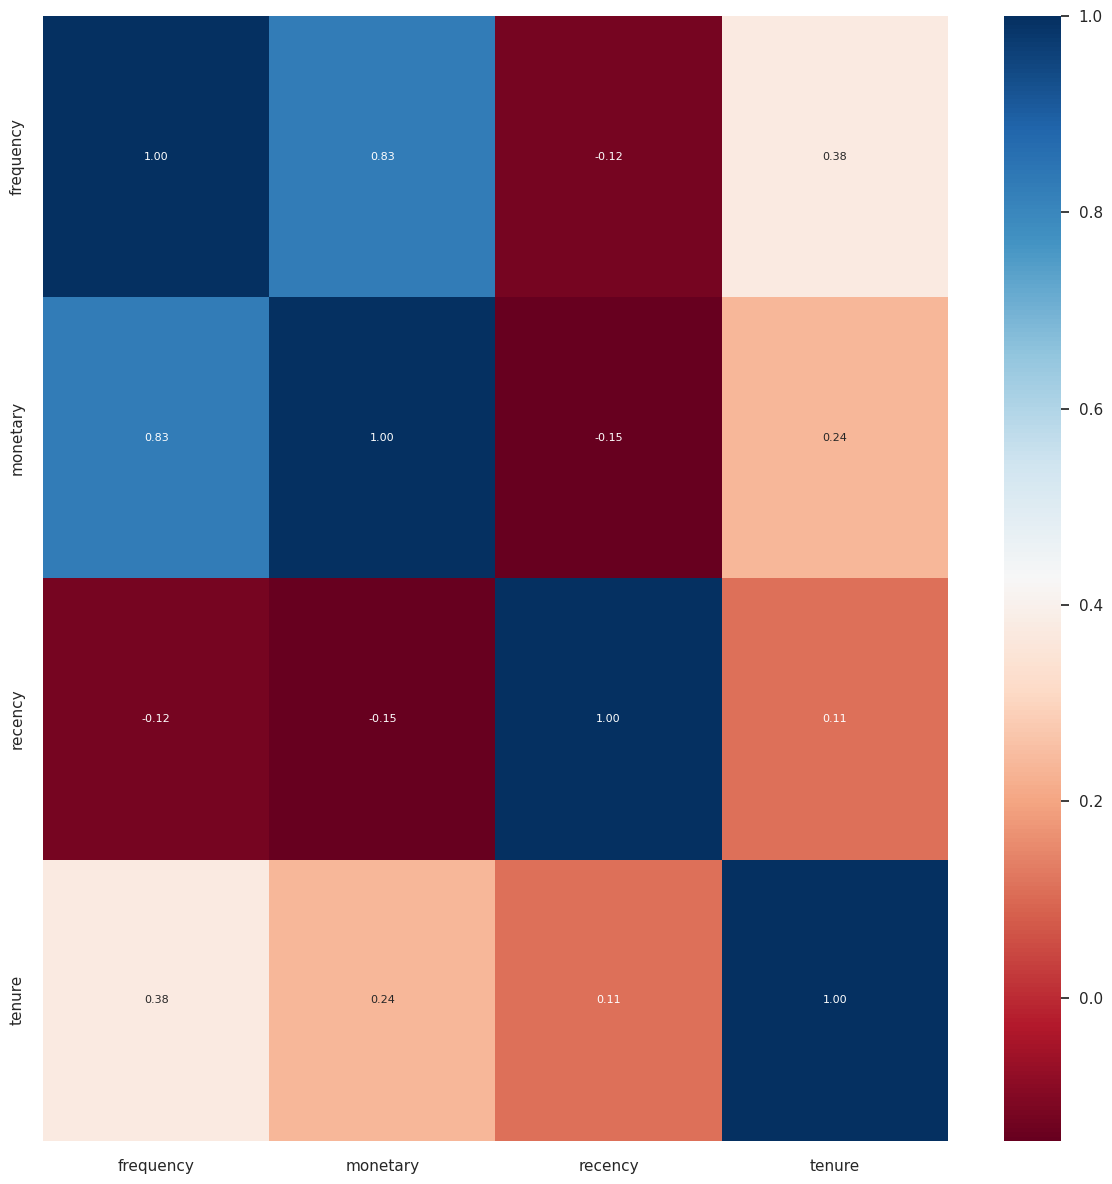

In [15]:
#Analysis of Correlation
corr = df.corr()
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f", annot_kws={"size": 8})
plt.tight_layout()
plt.show()

* Monetary ile Frequency arasinda %83'luk pozitif bir korelasyon gorulmektedir.

In [16]:
#scaling the dataset
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(df)
df[0:5] #df.head() wasn't applied here because after scaling the data, it turns to a numpy array.

#since we capped the outliers, we don't use robust scalar here. Standard scalar can be used as well. 

array([[0.06      , 0.10163593, 0.25479452, 0.06841244],
       [0.38      , 0.22370269, 0.28219178, 0.51358429],
       [0.06      , 0.0614027 , 0.50410959, 0.17905074],
       [0.        , 0.00874892, 0.36438356, 0.04615385],
       [0.        , 0.01875013, 0.23013699, 0.21702128]])

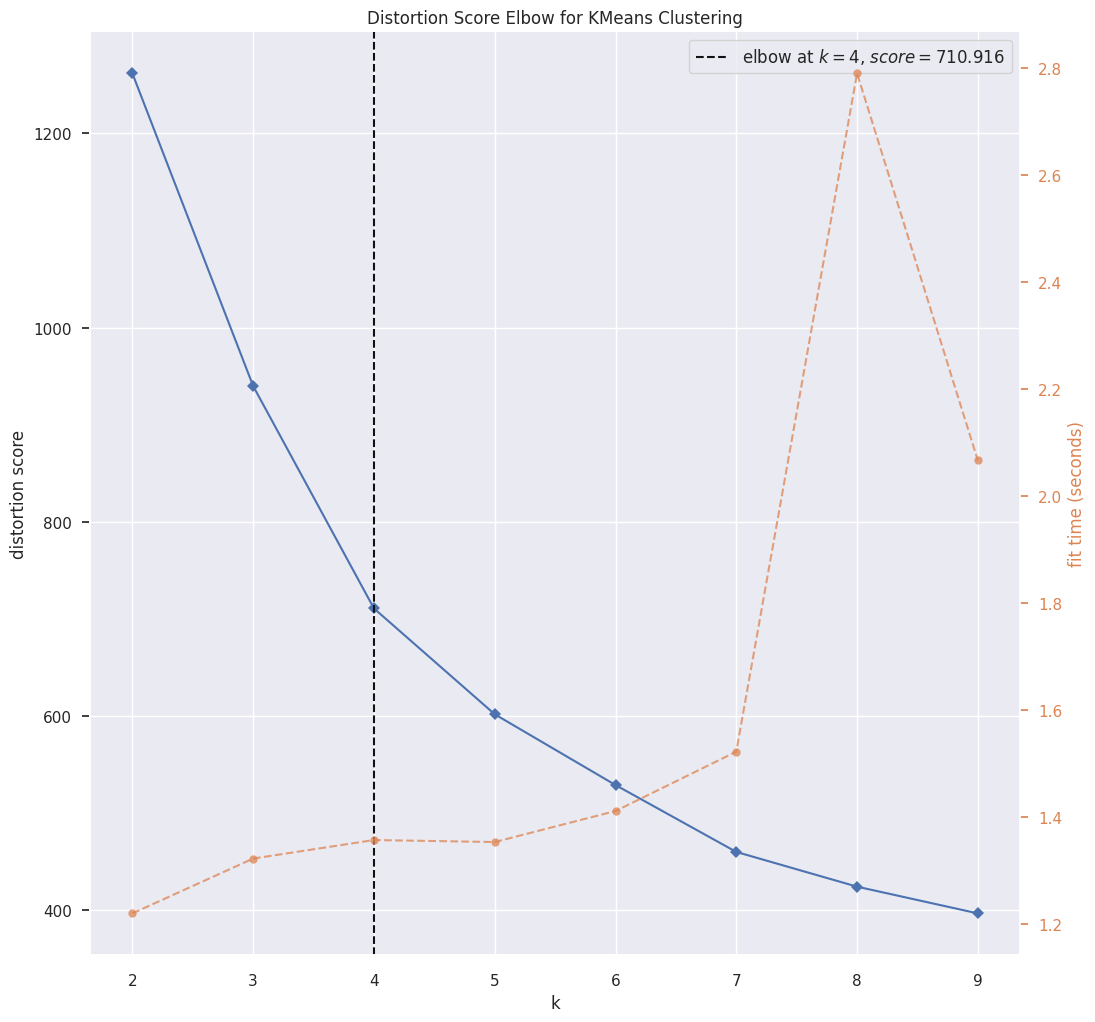

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# Initialize KElbowVisualizer with KMeans to find the optimal number of clusters
elbow = KElbowVisualizer(KMeans(random_state=42), k=(2, 10))
# Fit the visualizer to the data, calculating distortion scores for each k in the range
elbow.fit(df)
# Display the elbow plot, where the "elbow" indicates the optimal number of clusters
elbow.show()

In [18]:
# optimal clusters, showing teh optimal number of clusters
elbow.elbow_value_

4

In [19]:
#creating the model, segmenting the customers 
kmeans = KMeans(n_clusters=elbow.elbow_value_, random_state=42).fit(df)

In [20]:
#showing the number of clusters that the KMeans algorithm is using
kmeans.n_clusters

4

In [21]:
#showing the centroids of each cluster identified by the KMeans algorithm
kmeans.cluster_centers_

array([[0.05602667, 0.08141783, 0.11320728, 0.19370915],
       [0.04389879, 0.06133131, 0.82154289, 0.28762117],
       [0.16548243, 0.15202678, 0.27305349, 0.63356119],
       [0.03997648, 0.06363566, 0.43472621, 0.20758424]])

In [22]:
#Get the cluster labels for each data point in the dataset.
kmeans.labels_

array([0, 2, 3, ..., 0, 3, 1], dtype=int32)

In [23]:
#converting the numpy array to a dataframe with the following columns
df = pd.DataFrame(df, columns=["frequency", "monetary", "recency", "tenure"]) 

In [24]:
# we have 4 clusters(segments) but they start from zero, so add 1 to make them start from 1
df["Segment"] = kmeans.labels_ + 1

In [25]:
#displaying the first 5 obrsevations of the dataframe 'df'
df.head()

,frequency,monetary,recency,tenure,Segment
0,0.060,0.102,0.255,0.068,1
1,0.380,0.224,0.282,0.514,3
2,0.060,0.061,0.504,0.179,4
3,0.000,0.009,0.364,0.046,4
4,0.000,0.019,0.230,0.217,1


In [26]:
# grouping the 'Segment' and calculating mean, median, min, max, and the count of each variable in the dataframe
df.groupby("Segment").agg({"mean","median", "min", "max","count"})

frequency                         monetary                         recency                         tenure                        
           median   max count  mean   min   median   max count  mean   min  median   max count  mean   min median   max count  mean   min
Segment                                                                                                                                  
1           0.040 0.580  8101 0.056 0.000    0.061 1.000  8101 0.081 0.001   0.096 0.288  8101 0.113 0.000  0.195 0.506  8101 0.194 0.000
2           0.020 1.000  3868 0.044 0.000    0.047 0.969  3868 0.061 0.000   0.844 1.000  3868 0.822 0.567  0.228 0.996  3868 0.288 0.081
3           0.120 1.000  2025 0.165 0.000    0.107 1.000  2025 0.152 0.000   0.244 0.874  2025 0.273 0.000  0.622 1.000  2025 0.633 0.153
4           0.020 0.440  5951 0.040 0.000    0.050 0.606  5951 0.064 0.001   0.433 0.658  5951 0.435 0.263  0.202 0.536  5951 0.207 0.033

In [27]:
#grouping the dataFrame df by the "Segment" column and calculating Count of each segment, Recency_Mean, T_Mean, Frequency_Mean, Monetary_Mean
df.groupby("Segment").agg(Count=("Segment","count"),
                          Recency_Mean=("recency","mean"),
                          T_Mean=("tenure","mean"),
                          Frequency_Mean=("frequency","mean"),
                          Monetary_Mean=("monetary","mean"))

,Count,Recency_Mean,T_Mean,Frequency_Mean,Monetary_Mean
Segment,,,,,
1,8101,0.113,0.194,0.056,0.081
2,3868,0.822,0.288,0.044,0.061
3,2025,0.273,0.633,0.165,0.152
4,5951,0.435,0.207,0.040,0.064


In [28]:
#different version of grouping the dataframe
# print(df.groupby("Segment").agg(Count=("Segment","count"),
#                           Recency=("recency", lambda x: f" Mean: {x.mean():.0f}, Max:{x.max()}, Min:{x.min()}"),
#                           T=("tenure", lambda x: f" Mean: {x.mean():.0f}, Max:{x.max()}, Min:{x.min()}"),
#                           Frequency=("frequency", lambda x: f" Mean: {x.mean():.0f}, Max:{x.max()}, Min:{x.min()}"),
#                           Monetary=("monetary", lambda x: f" Mean: {x.mean():.0f}, Max:{x.max():.0f}, Min:{x.min():.0f}")).to_markdown())

**Champions - Segment 3;** High values in frequency mean, monetary mean, and relatively low recency mean, indicating active and valuable customers.Tenure is relatively high, indicating they’ve been around longer.

**Loyal Customers - Segment 4;** Moderate to high frequency and monetary values with mid-range tenure, showing consistent interaction without as high activity as "Champions." Recency values are moderate, indicating relatively recent engagement but not as active as Champions.

**Potential Loyalists / Loyals - Segment 1;** Lower monetary and frequency scores compared to Champions and Loyals but not completely inactive.
Recency is low, indicating they’ve been recent but less frequent.

**At Risk - Segment 2;** High recency (less recent), indicating these customers haven't interacted recently.
Tenure is lower, and while they have interacted in the past, they’ve become inactive, and thus the segment might need attention to prevent churn.


**Targeted Strategies:**

**Champions and Loyals:** Focus on retention and growth through exclusive rewards, personalized experiences, and engagement.

**Potential Loyalists:** Focus on nurturing to build loyalty, encouraging more frequent purchases, and developing a stronger brand connection.

**At-Risk Customers:** Focus on re-engagement and win-back through targeted offers and understanding barriers to their continued engagement.


## Customer Segmentation with Hierarchical Clustering

In [29]:
hc = linkage(df, "ward")

These clustering methods define how the distance between clusters is measured in hierarchical clustering:

**Single Linkage:** Minimum distance between clusters.

**Complete Linkage:** Maximum distance between clusters.

**Average Linkage:** Average distance between clusters.

**Centroid Linkage:** Distance between cluster centroids (centers).

**The Ward method** is a clustering technique that minimizes the variance within clusters. It merges clusters in a way that results in the smallest possible increase in total within-cluster variance, leading to more compact and homogeneous clusters.


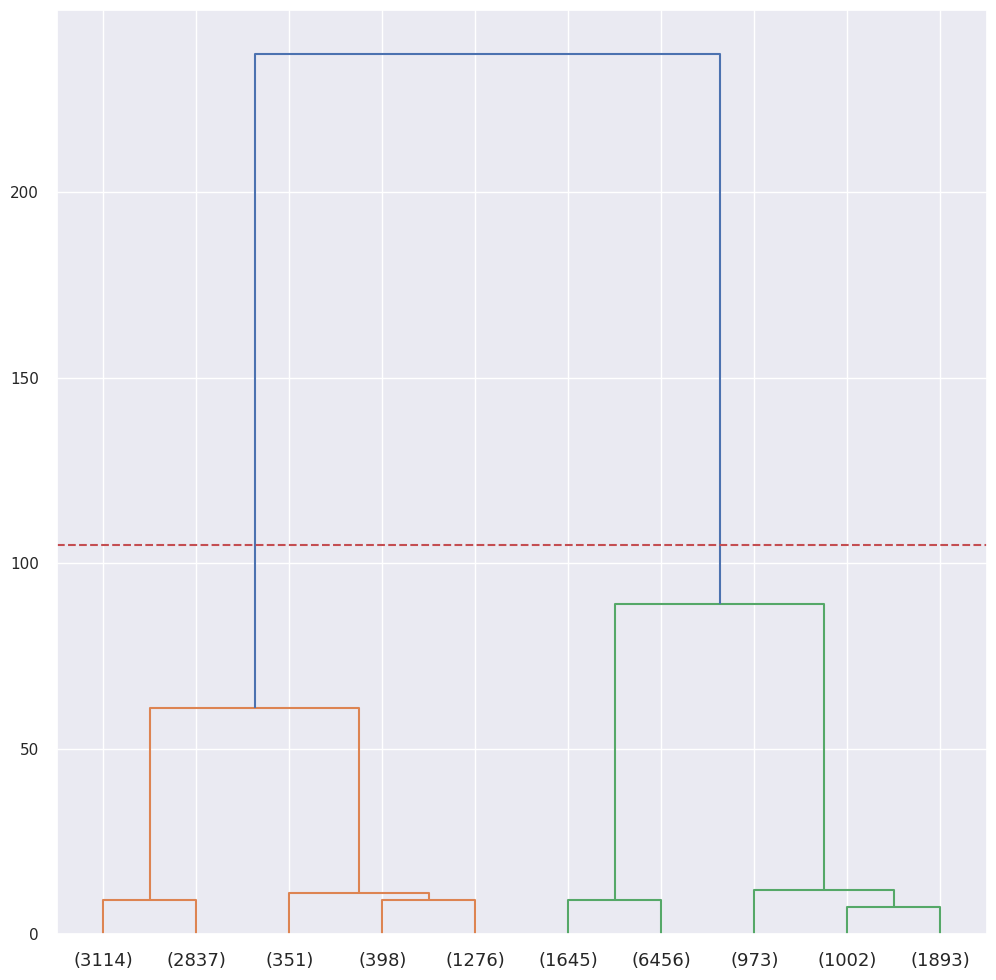

In [30]:
#plotting the dendogram, it is used in hierarchical clustering to visualize the arrangement of clusters and the distances between them.
dendrogram(hc,
           truncate_mode="lastp", #A parameter that specifies how the dendrogram will be cropped. The lastp option means that the last p cluster will be shown.
           p=10, # specifies the number of last p clusters to display.
           show_contracted=False, # A parameter indicating that clustering nodes are combined
           leaf_font_size=13) #Leaf nodes font size
plt.axhline(y=105, color='r', linestyle='--')
plt.show()

#y is the cut-off point for cluster separation (red line)

In [31]:
#creating the model
df["Hc_Segments"] = fcluster(hc, 105, criterion="distance")

In [32]:
df.head()

,frequency,monetary,recency,tenure,Segment,Hc_Segments
0,0.060,0.102,0.255,0.068,1,2
1,0.380,0.224,0.282,0.514,3,1
2,0.060,0.061,0.504,0.179,4,1
3,0.000,0.009,0.364,0.046,4,1
4,0.000,0.019,0.230,0.217,1,2


In [33]:
# grouping the 'Agg_Segments' and calculating mean, median, min, max, and the count of each variable in the dataframe
df.groupby("Hc_Segments").agg({"recency":["count","min","max","mean"],
                           "tenure": ["min","max","mean"],
                           "frequency":["min","max","mean"],
                           "monetary":["min","max","mean"]})

recency                   tenure             frequency             monetary            
              count   min   max  mean    min   max  mean       min   max  mean      min   max  mean
Hc_Segments                                                                                        
1              7976 0.000 0.874 0.394  0.033 1.000 0.316     0.000 1.000 0.072    0.000 1.000 0.086
2             11969 0.000 1.000 0.342  0.000 0.996 0.224     0.000 1.000 0.052    0.000 1.000 0.075

**Hc_Segments 2:** This segment likely stands out with higher customer loyalty and spending capacity. To strengthen loyalty, strategies such as loyalty programs, personalized promotions, or exclusive discounts could be implemented for these customers.

**Hc_Segments 1:** For this segment, strategies to increase shopping frequency could be developed. Examples include welcome discounts, small gifts, or discounts after reaching a certain spending threshold to encourage more frequent purchases.

# Customer Segmentation with Agglomerative Clustering

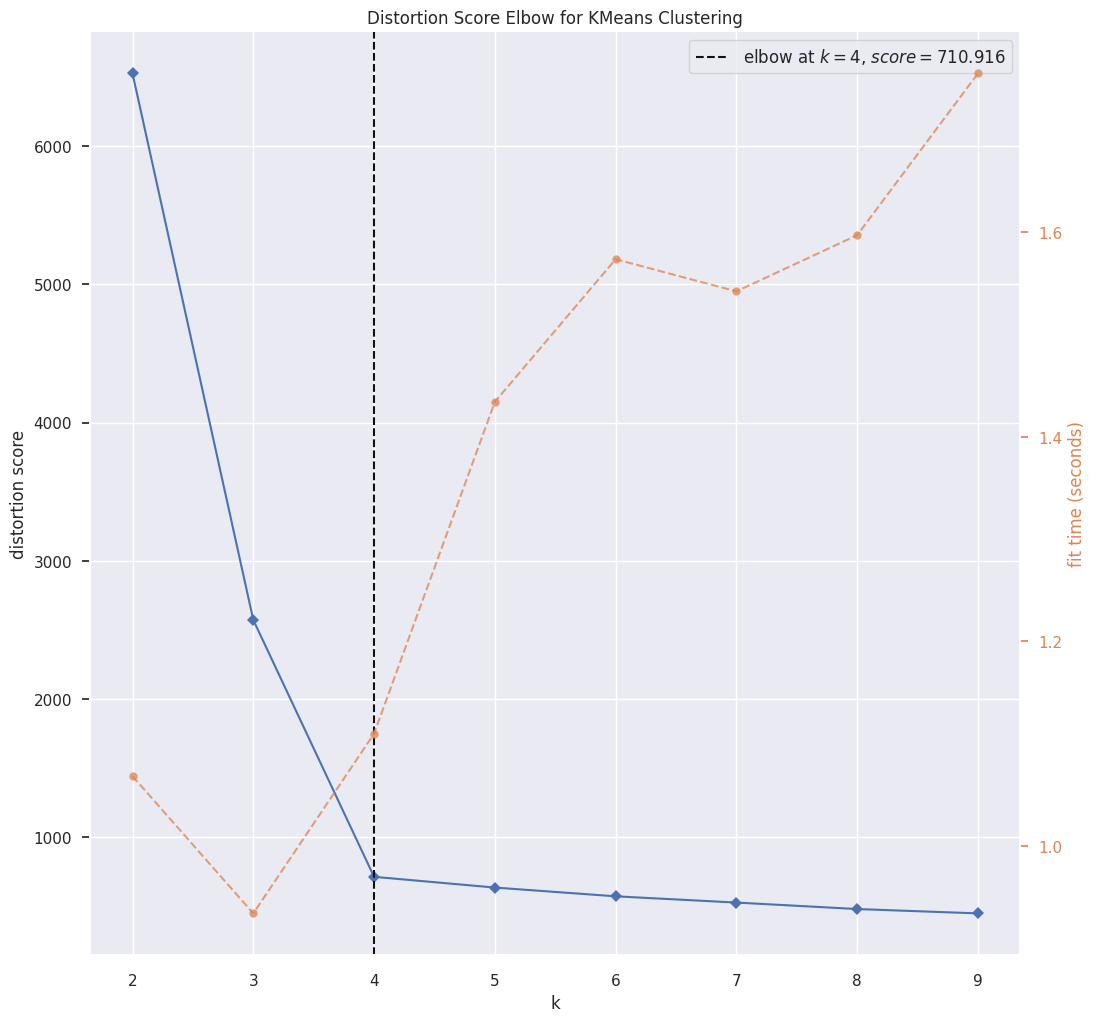

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
# Initialize KElbowVisualizer with KMeans to find the optimal number of clusters
elbow = KElbowVisualizer(KMeans(random_state=42), k=(2,10))
elbow.fit(df)
elbow.show()

In [35]:
# optimal clusters, showing teh optimal number of clusters
elbow.elbow_value_

4

In [36]:
# creates an agglomerative clustering model that will form clusters 
# based on the Ward linkage approach, with the number of clusters determined by the elbow method
cluster = AgglomerativeClustering(n_clusters=elbow.elbow_value_, linkage="ward")

In [37]:
# Fitting and predicting the clusters
clusters = cluster.fit_predict(df)

In [38]:
#initilazing the clusters from 1 instead of 0 'zero'
df["Agg_Segments"] = clusters + 1

In [39]:
df.head()

,frequency,monetary,recency,tenure,Segment,Hc_Segments,Agg_Segments
0,0.060,0.102,0.255,0.068,1,2,3
1,0.380,0.224,0.282,0.514,3,1,2
2,0.060,0.061,0.504,0.179,4,1,4
3,0.000,0.009,0.364,0.046,4,1,4
4,0.000,0.019,0.230,0.217,1,2,3


In [40]:
# grouping the 'Agg_Segments' and calculating mean, median, min, max, and the count of each variable in the dataframe
df.groupby("Agg_Segments").agg({"recency":["count","min","max","mean"],
                           "tenure": ["min","max","mean"],
                           "frequency":["min","max","mean"],
                           "monetary":["min","max","mean"]})

recency                   tenure             frequency             monetary            
               count   min   max  mean    min   max  mean       min   max  mean      min   max  mean
Agg_Segments                                                                                        
1               3868 0.567 1.000 0.822  0.081 0.996 0.288     0.000 1.000 0.044    0.000 0.969 0.061
2               2025 0.000 0.874 0.273  0.153 1.000 0.633     0.000 1.000 0.165    0.000 1.000 0.152
3               8101 0.000 0.288 0.113  0.000 0.506 0.194     0.000 0.580 0.056    0.001 1.000 0.081
4               5951 0.263 0.658 0.435  0.033 0.536 0.207     0.000 0.440 0.040    0.001 0.606 0.064

**Agg_Segments 1**: Long-term inactive customers — re-engagement needed.

**Agg_Segments 2:** Loyal, high-spending customers — reward their loyalty.

**Agg_Segments 3:** New, low-engagement customers — incentivize engagement.

**Agg_Segments 4:** New, moderately engaged customers — encourage frequent purchases.